# Загрузка

In [1]:
targets = ['Врем. сопротивление', 'Предел текучести']

In [2]:
ls_bath_col = [
    't˚ C воды в закалочной ванне', 
    't˚ C трубы после ванны',
    'время выдержки в закалочной ванне, сек.'
]

In [85]:
ls_need_col = ['Врем. сопротивление', 'Предел текучести',
       'Тип предела текучести (1186)',
       '1 зона по ВТР закалка',
       '2 зона по ВТР закалка',
       '3 зона по ВТР закалка',
       'Скорость прохождения трубы через спрейер, м/с',
       't˚ C трубы после спреера',
#        't˚ C воды в закалочной ванне', 
       't˚ C трубы после ванны',
       'время выдержки в закалочной ванне, сек.',
       '1 зона ВТР и уставка отпуск', 
       '2 зона ВТР и уставка отпуск',
       '3 зона ВТР и уставка отпуск',
       '4 зона ВТР и уставка отпуск',
       '5 зона ВТР и уставка отпуск',
       'диаметр', 
       'марка стали',
       'толщина стенки', 
       'шаг балок закалочная печь, сек',
       'шаг балок отпускная печь, сек',
       'C', 'Mn', 'Si', 'P', 'S',
       'Cr', 'Ni', 'Cu', 'Al', 'V', 'Ti', 'Nb', 'Mo', 'N',
       'ICD',
       'C-coef', 'Параметр закалка', 'Параметр отпуск',
       'Параметр отпуск новый', 'Параметр отпуск новый 2',
       'Параметр отпуск новый V',
       'Величина зерна']

In [16]:
import pandas as pd
import numpy as np
import import_ipynb
from my_libs.calc_features import *
import random
from datetime import datetime

In [27]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate, train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn import model_selection
import time
from sklearn.neural_network import MLPRegressor
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
from sklearn.preprocessing import LabelEncoder
from time import time
from datetime import datetime
import json
from my_libs.save_lib import save_RF_model
from scipy.stats.stats import pearsonr

importing Jupyter notebook from C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\save_lib.ipynb


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [44]:
df = pd.read_excel('DATA/prepared/prepared_hard.xlsx')

In [45]:
df_valid = pd.read_excel('DATA/prepared/prepared_hard_valid.xlsx')

# Отделение таблицы с ванной и ее преобразование

In [58]:
bath = df[~df['время выдержки в закалочной ванне, сек.'].isnull()].copy()
bath_valid = df_valid[~df_valid['время выдержки в закалочной ванне, сек.'].isnull()].copy()
df_ = df[df['время выдержки в закалочной ванне, сек.'].isnull()].copy()
df_valid_ = df_valid[df_valid['время выдержки в закалочной ванне, сек.'].isnull()].copy()

In [59]:
bath.shape, bath_valid.shape

((952, 211), (148, 200))

In [60]:
bath = bath[bath['время выдержки в закалочной ванне, сек.'] > 10]

bath_valid = bath_valid[ls_need_col]
bath = bath[ls_need_col]

bath.shape, bath_valid.shape

((930, 42), (148, 42))

In [61]:
def bath2spr(df):
    L = 8.4
    df['Скорость прохождения трубы через спрейер, м/с'] = L/df['время выдержки в закалочной ванне, сек.']
    df['t˚ C трубы после спреера'] = df['t˚ C трубы после ванны']
    return df

In [62]:
bath = bath2spr(bath)
bath_valid = bath2spr(bath_valid)

In [63]:
df_.shape, df_valid_.shape, bath.shape, bath_valid.shape

((21823, 211), (1580, 200), (930, 42), (148, 42))

In [68]:
df = pd.concat([df_, bath])
df.reset_index(inplace=True, drop=True)
df_valid = pd.concat([df_valid_, bath_valid])
df_valid.reset_index(inplace=True, drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
df.shape, df_valid.shape

((22753, 211), (1728, 200))

# Обучение

In [93]:
ls_train_col = ls_need_col.copy()
for s in targets+['t˚ C трубы после ванны',
       'время выдержки в закалочной ванне, сек.', 'марка стали']:
    ls_train_col.remove(s) 

In [143]:
df_clean = df[ls_train_col+targets].dropna()
df_valid_clean = df_valid[ls_train_col+targets].dropna()

In [144]:
df_clean.shape, df_valid_clean.shape

((21797, 39), (1613, 39))

In [145]:
X = df_clean[ls_train_col]
y = df_clean[targets]
X_valid = df_valid_clean[ls_train_col]
y_valid = df_valid_clean[targets]

In [146]:
def print_and_return_score(x, y, est):
    y_pred = est.predict(x)
    scr = est.score(x, y)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    corr = []
    for i in range(y.columns.size):
        corr.append(np.corrcoef(y.iloc[:, i].T, 
                                y_pred[:, i]))
        
    print('Score: ', round(scr, 2))
    print('R^2: ', round(r2, 2))
    print('MAE: ', round(mae, 2))
    print('MSE: ', round(mse, 2))
    print('Correlation Врем. сопротивление: ', round(corr[0][0][1], 2))
    print('Correlation Предел текучести: ', round(corr[1][0][1], 2))
    return [scr, mae, mse, corr[0][0][1], corr[1][0][1]]

In [148]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3)

rfc = RandomForestRegressor(max_features = 10, max_depth = 15, min_samples_leaf = 2, n_estimators=100, criterion='mse')
rfc.fit(X_train, y_train)

scr, mae, mse, corr1, corr2 = print_and_return_score(X_test, y_test, rfc)

Score:  0.9
R^2:  0.9
MAE:  1.97
MSE:  7.99
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94


In [180]:
score_df = pd.concat([pd.DataFrame({'Score':[scr], 'MAE':[mae], 'MSE':[mse], 'Correlation Врем. сопротивление':[corr1],
                                                     'Correlation Предел текучести':[corr2]}),
                      pd.DataFrame(rfc.predict(X_valid), columns=['прогноз Врем. сопротивление', 'прогноз Предел текучести']),
                      y_valid],
                    axis=1)

In [183]:
save_RF_model(rfc, ls_train_col, 'H+YS', score_df)

Модель сохранена


## GridSearchCV

In [184]:
param_grid = {
    'max_depth': range(6, 18, 2),
    'max_features': range(6, 18, 2),
    'min_samples_leaf': range(1, 5),
    'n_estimators': range(50, 300, 50)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_error')

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   49.9s


In [110]:
grid_search.best_params_

{'max_depth': 16,
 'max_features': 16,
 'min_samples_leaf': 3,
 'n_estimators': 150}

In [111]:
scr, mae, mse, corr, y_pred = print_and_return_score(X_test, y_test, grid_search)

Score:  -1.96
R^2:  0.9
MAE:  1.96
MSE:  7.81
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94


In [140]:
y_predict = grid_search.predict(X_test)

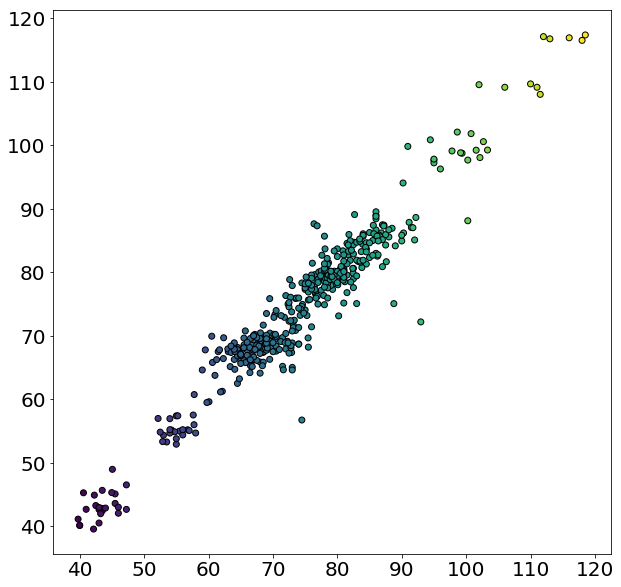

In [141]:
plt.subplots(figsize=(10,10))
plt.scatter(y_test, y_predict, marker='o', c=y_test, edgecolors='black', cmap='viridis')
# plt.colorbar()
plt.show()

## Cross-validation with KFold

In [141]:
kfold = model_selection.KFold(n_splits=5, shuffle=True)
scores = []
for train, test in kfold.split(X, y):
    x_train, y_train = X.iloc[train], y.iloc[train]
    x_test, y_test = X.iloc[test], y.iloc[test]
#     grf = grid_search.best_estimator_
    rfc.fit(x_train, y_train)

    scores.append(print_and_return_score(X_valid, y_valid, rfc))

Score:  0.89
R^2:  0.89
MAE:  2.91
MSE:  15.7
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.9
R^2:  0.9
MAE:  2.84
MSE:  14.81
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.95
Score:  0.89
R^2:  0.89
MAE:  2.89
MSE:  15.73
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.9
R^2:  0.9
MAE:  2.84
MSE:  14.82
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.9
R^2:  0.9
MAE:  2.83
MSE:  14.58
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94


In [142]:
for i in range(5):
    tmp = []
    for j in range(5):
        tmp.append(scores[j][i])
    print(round(np.mean(tmp), 2))

0.89
2.86
15.13
0.96
0.94
